# IMPORTS AND SETUP

In [1]:
%matplotlib inline
import pandas as pd
import random
import tkinter as tk
from tkinter.ttk import *
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from enum import Enum
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import time
import math
from matplotlib import colors


# FUNCTIONS

In [2]:
def sum_of_array(an_array):
    sum = 0 
    for i in an_array:
        sum += i
    return sum

In [3]:
def normalize_language_dependence(game):
    sum_of_weighted_language = 0
    total_num_votes = 0
    for level in game:
        value_key = level['@value'].split(' ')[0].upper()
        language_multiplier = language_value[value_key]
        votes = int(level['@numvotes'])
        total_num_votes += votes
        sum_of_weighted_language += language_multiplier * votes
    return (sum_of_weighted_language / total_num_votes) if total_num_votes > 0 else 0

In [4]:
def add_brackets_and_eval(string_item):
    string_item = str(string_item)
    if string_item[0] != '[':
        string_item = '[' + str(string_item)
    if string_item[-1] != ']':
        string_item = str(string_item) + ']'
    return eval(string_item)

In [5]:
def is_empty_playercount(game):
    for playercount in game:
        if 'result' in playercount:
            return True
        else: 
            return False

In [6]:
def calculate_age_from_ordered_dict(game):
    weighted_age_sum = 0
    total_votes = 0
    for age in game:
        votes = age['@numvotes']
        if age['@value'].isnumeric():
            age_num = age['@value']
        else:
            age_num = 25
        weighted_age_sum += int(age_num) * int(votes) 
        total_votes += int(votes)
    if total_votes:
        return weighted_age_sum/total_votes
    else:
        return 0

In [7]:
def calculate_players_from_ordered_dict(game):
    playercount_normalized_results = {}
    for playercount in game:
        if not 'result' in playercount:
            return 0
        total_votes = 0
        result_total_result = 0
        result_normalized_result = 0
        for result in playercount['result']:
            current_player_count = result['@value']
            multiplier = result_value[result['@value'].upper().replace(' ', '')]
            total_votes += int(result['@numvotes'])
            result_total_result += int(result['@numvotes']) * multiplier
        if(total_votes):
            result_normalized_result = result_total_result / total_votes
        else:
            result_normalized_result = 0
            result_normalized_result = 0
        playercount_normalized_results[playercount['@numplayers']]=result_normalized_result
    sum_of_weighted_players = 0
    sum_of_keys = 0
    num_of_keys = 0
    for key in playercount_normalized_results.keys():
        if not key.isnumeric():
            num = int(key[:-1]) + 1
        else:
            num = int(key)
        sum_of_weighted_players += num * (playercount_normalized_results[key]/3)
        sum_of_keys += num
        num_of_keys += 1
    return (sum_of_weighted_players)/(sum_of_keys/num_of_keys)


In [8]:
def plot_train_clusters():
    plt.scatter(train_set.iloc[:, 0], train_set.iloc[:, 1], c=y_kmeans, s=1, alpha=.4, cmap=cmap)

    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
    plt.plot(range(-20,20), [0]*40, '-', linewidth=1)
    plt.plot( [0]*40, range(-20,20), '-', linewidth=1)

In [9]:
def plot_test_clusters():
    plt.scatter(test_set.iloc[:, 0], test_set.iloc[:, 1], c=y_testkmeans, s=1, alpha=.4, cmap=cmap)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
    plt.plot(range(-20,20), [0]*40, '-', linewidth=1)
    plt.plot( [0]*40, range(-20,20), '-', linewidth=1)

In [10]:
def plot_kmeans_actual_pred():
    new_array = []
    pred_vals = reg.predict(test_set)
    for i in range(0,len(pred_vals)):
        new_array.append(abs(y_testkmeans[i] - pred_vals[i]))

    print(max(y_testkmeans))
    print(min(y_testkmeans))
    print(max(pred_vals))
    print(min(pred_vals))
    print(sum_of_array(new_array)/len(new_array))

    plt.scatter(pred_vals, y_testkmeans, c=y_testkmeans, s=5, alpha=.2, marker='o', cmap=cmap)
    plt.plot(pred_vals, pred_vals, '-')

In [11]:
def predict_game_cluster(game_id_list):
    global clean_detailed_info
    global reg
    number_of_features = len(clean_detailed_info.columns) - 1
    games = np.empty((0,number_of_features), float)
    for game_id in game_id_list:
        games = np.append(games, np.array([clean_detailed_info.iloc[game_id].drop('cluster')]), axis=0)
    average_of_games = np.average(games, axis=0)
    scaled_average = scaler.transform(average_of_games.reshape(1, -1))
    pca_average = pca_set.transform(scaled_average)
    predicted_cluster = reg.predict(pca_average)
    if predicted_cluster - math.floor(predicted_cluster) <= .5:
        predicted_cluster = math.floor(predicted_cluster)
    else:
        predicted_cluster = math.ceil(predicted_cluster)
    if predicted_cluster < 0:
        predicted_cluster = 0
    elif predicted_cluster > 5:
        predicted_cluster = 5

    
    return predicted_cluster

In [12]:
def count_predicted_clusters():
    from collections import Counter
    predictionlist = []
    for i in range(1000):
        game_id_list = [random.randrange(10000)]*random.randrange(3,10)
        predictionlist.append(predict_game_cluster(game_id_list))
    predicted_counts = Counter(predictionlist)
    for i in range(6):
        print(str(i) + ': happens this often - ' + str(predicted_counts[i]/1000))

In [13]:
def plot_all_clusters():
    plt.scatter(principalComponentsGamesDF.iloc[:, 0], principalComponentsGamesDF.iloc[:, 1], c=all_games_kmeans, s=1, alpha=.4, cmap=cmap)
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5);
    plt.plot(range(-20,20), [0]*40, '-', linewidth=1)
    plt.plot( [0]*40, range(-20,20), '-', linewidth=1)

In [14]:
def count_cluster_distribution():
    all_counts = Counter(all_games_kmeans)

    for i in range(6):
        print(str(i) + ': happens this often - ' + str(all_counts[i]/len(all_games_kmeans)))

In [15]:
def avg_dif_predicted_actual():
    sum_average = {'predicted' : 0, 'actual': 0}
    len_actual = len(all_games_kmeans)
    len_predicted = len(predictionlist)
    for i in range(6):
        prob_predicted = predicted_counts[i]/len_predicted
        prob_actual = all_counts[i]/len_actual
        print(str(i) + ': happens this often in all games - ' + str(prob_actual))
        print(str(i) + ': happens this often in predicted games- ' + str(prob_predicted))
        print('\nThe difference is ' + str(prob_actual - prob_predicted) + '\n\n\n')
        sum_average['predicted'] += prob_predicted
        sum_average['actual'] += prob_actual
    print(sum_average)
    

In [16]:
def show_window():

    window = tk.Tk()
    window.title('Board Game Suggestor')
    choice_one_label = Label(window, text='CHOICE #1')
    choice_one_label.grid(row=1,column=1)
    game_choice_one = Combobox(window, textvariable=['test1', 'test2', 'test3'], values=[1,2,3])
    game_choice_one.grid(row=1,column=2, pady=15, padx=10)

    choice_two_label = Label(window, text='CHOICE #2')
    choice_two_label.grid(row=2,column=1)
    game_choice_two = Combobox(window, textvariable=['test1', 'test2', 'test3'], values=[1,2,3])
    game_choice_two.grid(row=2,column=2, pady=15, padx=10)

    choice_three_label = Label(window, text='CHOICE #3')
    choice_three_label.grid(row=3,column=1)
    game_choice_three = Combobox(window, textvariable=['test1', 'test2', 'test3'], values=[1,2,3])
    game_choice_three.grid(row=3,column=2, pady=15, padx=10)

    choice_four_label = Label(window, text='CHOICE #4')
    choice_four_label.grid(row=4,column=1)
    game_choice_four = Combobox(window, textvariable=['test1', 'test2', 'test3'], values=[1,2,3])
    game_choice_four.grid(row=4,column=2, pady=15, padx=10)

    choice_five_label = Label(window, text='CHOICE #5')
    choice_five_label.grid(row=5,column=1)
    game_choice_five = Combobox(window, textvariable=['test1', 'test2', 'test3'], values=[1,2,3])
    game_choice_five.grid(row=5,column=2, pady=15, padx=10)


    get_results_button = Button(text='Get My Results')
    get_results_button.grid(row=7, column=1, pady=15, padx=15)

    window.mainloop()

# APPLICATION

In [17]:
random_seed = 222
# red=0, green=1, blue=2, cyan=3, magenta=4, yellow=5
cmap = colors.ListedColormap(['r','g','b','c','m', 'y'])
result_value = {
    'BEST' : 3,
    'RECOMMENDED' : 2,
    'NOTRECOMMENDED' : 1   
}

language_value = {
    'NO' : 1,
    'SOME' : 2,
    'MODERATE' : 3,
    'EXTENSIVE' : 4,
    'UNPLAYABLE' : 5
}

unclean_detailed_info = pd.read_csv('..\Resources\BoardGames\games_detailed_info.csv')
clean_detailed_info = unclean_detailed_info.drop(['Unnamed: 0', 'type', 'id', 'thumbnail', 'image', 'primary',
       'alternate', 'description', 'yearpublished', 'boardgameexpansion', 'boardgameimplementation',
       'boardgamedesigner', 'boardgameartist', 'boardgamepublisher', 'boardgameintegration', 'boardgamecompilation', 'boardgamecategory',
       'boardgamemechanic', 'boardgamefamily', 'RPG Item Rank', 'Accessory Rank', 'Video Game Rank', 'Amiga Rank',
       'Commodore 64 Rank', 'Arcade Rank', 'Atari ST Rank'], axis=1)

In [18]:
clean_detailed_info = clean_detailed_info.fillna(0)
clean_detailed_info['suggested_num_players'] = clean_detailed_info['suggested_num_players'].apply(add_brackets_and_eval)
clean_detailed_info['suggested_num_players'] = clean_detailed_info['suggested_num_players'].apply(calculate_players_from_ordered_dict)
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_playerage'] != 0]
clean_detailed_info['suggested_playerage'] = clean_detailed_info['suggested_playerage'].apply(add_brackets_and_eval)
clean_detailed_info['suggested_playerage'] = clean_detailed_info['suggested_playerage'].apply(calculate_age_from_ordered_dict)
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_language_dependence'] != 0]
clean_detailed_info['suggested_language_dependence'] = clean_detailed_info['suggested_language_dependence'].apply(add_brackets_and_eval)
clean_detailed_info['suggested_language_dependence'] = clean_detailed_info['suggested_language_dependence'].apply(normalize_language_dependence)
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_num_players'] > 0]
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_playerage'] > 0]
clean_detailed_info = clean_detailed_info[clean_detailed_info['suggested_language_dependence'] > 0]

In [19]:
scaler = StandardScaler().fit(clean_detailed_info)
scaled_set = scaler.transform(clean_detailed_info)
pca_set = PCA(n_components=2, random_state=random_seed)
principalComponentsGames = pca_set.fit_transform(scaled_set)
principalComponentsGamesDF = pd.DataFrame(data=principalComponentsGames, columns = ['PC1', 'PC2'])
train_set, test_set = train_test_split(principalComponentsGamesDF, test_size=0.2, random_state=random_seed, shuffle=True)
kmeans = KMeans(n_clusters=6, random_state=random_seed)
kmeans.fit(train_set)
y_kmeans = kmeans.predict(train_set)
y_testkmeans = kmeans.predict(test_set)
#putting the cluster number in the unclean data set to retrieve results from later
all_games_kmeans = kmeans.predict(principalComponentsGamesDF)
reg = LinearRegression().fit(train_set, y_kmeans)
clean_detailed_info['cluster'] = all_games_kmeans.tolist()
unclean_detailed_info['cluster'] = clean_detailed_info['cluster']

In [143]:
for i in range(100):
    print(predict_game_cluster([random.randrange(12000)]))

1
3
2
3
2
3
1
2
2
2
3
2
1
3
2
2
1
2
2
2
2
3
2
4
1
1
3
1
1
2
3
3
2
1
1
3
1
3
4
2
2
2
2
2
2
1
1
3
2
3
2
3
2
2
3
2
2
2
1
2
1
1
3
1
2
1
2
3
1
1
2
5
2
2
3
3
2
1
3
2
3
3
0
2
1
1
3
4
3
2
1
2
3
2
3
2
3
3
2
2


5
0
5.576337055468887
-1.17696192410913
1.3039212051034532


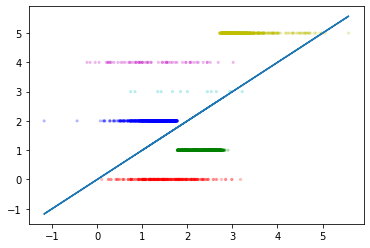

In [144]:
plot_kmeans_actual_pred()

In [146]:
print(reg.coef_)

[-0.12406399 -0.44433535]


# TESTING

# STAGING